In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [252]:
import os
import json
import time
import pickle
from multiprocessing import Pool
import itertools

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd
import statsmodels.api as sm

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from bprime.utils import index_cols
from bprime.plots import surface_plot
from bprime.learn import LearnedFunction
from bprime.theory import bgs_segment, bgs_rec

os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [253]:
lowess = sm.nonparametric.lowess

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')


In [250]:
def log_tick_formatter(val, pos=None):
    return f"$10^{{{np.round(val, 1)}}}$"

In [6]:
bgs_rec(1e-8, 1e-3, 1e-8, 1e3)

array(0.99005003)

## Data

In [7]:
with open('../slim_sims/classic_bgs.json') as f:
    sim_params = json.load(f)
sim_params

{'name': 'classicbgs',
 'params': {'N': {'lower': 1000, 'upper': 1000, 'log10': False, 'type': 'int'},
  'mu': {'lower': 5.5e-09, 'upper': 1e-05, 'log10': False, 'type': 'float'},
  's': {'lower': -4, 'upper': -1, 'log10': True, 'type': 'float'},
  'h': {'lower': 0.5, 'upper': 0.5, 'log10': False, 'type': 'float'},
  'rbp': {'lower': 1.1e-08, 'upper': 1.1e-08, 'log10': False, 'type': 'float'},
  'recfrac': {'lower': -8, 'upper': -6, 'log10': True, 'type': 'float'},
  'seglen': {'lower': 1000, 'upper': 1000, 'log10': False, 'type': 'int'}},
 'init_runtime': 0.25,
 'nsamples': 100000}

In [8]:
sim_data = np.load('../data/slim_sims/B_data.npz', allow_pickle=True)

In [9]:
Xcols = index_cols(sim_data['features'])
ycols = index_cols(sim_data['targets'])
sim_data['features'], sim_data['targets']

(array(['N', 's', 'h', 'mu', 'recfrac', 'rbp', 'seglen'], dtype='<U7'),
 array(['pi', 'Bhat', 'Ef', 'Vf', 'load'], dtype='<U4'))

In [10]:
assert(len(sim_data['features']) == sim_data['X'].shape[1])

In [248]:
Xo, yo = np.array(sim_data['X']), sim_data['y']
Xo.shape

(57783, 7)

In [12]:
# how strong is selection?
(Xo[:, 1] > 1e-3).mean()

0.669124136856861

To be aligned with classic BGS theory, let's parameterize the heterozygous effect as $sh$. We build up our training dataset:

In [13]:
X = np.hstack((Xo[:, Xcols('mu')], np.prod(Xo[:, Xcols('s', 'h')], axis=1)[:, None], Xo[:, Xcols('recfrac')]))
X

array([[5.3880e-06, 3.6275e-03, 1.9010e-08],
       [6.3350e-06, 6.1650e-04, 3.3870e-08],
       [6.4200e-06, 2.8550e-03, 1.4250e-07],
       ...,
       [5.2750e-07, 8.6100e-03, 1.1690e-07],
       [6.7120e-06, 2.1320e-04, 4.1970e-08],
       [3.2460e-06, 9.6400e-05, 5.0280e-07]])

Now extract the target, $\hat{B}$.

In [14]:
y = yo[:, ycols('Bhat')]

Use the `LearnedFunction` class to store data, etc.

In [15]:
X

array([[5.3880e-06, 3.6275e-03, 1.9010e-08],
       [6.3350e-06, 6.1650e-04, 3.3870e-08],
       [6.4200e-06, 2.8550e-03, 1.4250e-07],
       ...,
       [5.2750e-07, 8.6100e-03, 1.1690e-07],
       [6.7120e-06, 2.1320e-04, 4.1970e-08],
       [3.2460e-06, 9.6400e-05, 5.0280e-07]])

In [16]:
domain = {p: sim_params['params'][p] for p in ('mu', 's', 'recfrac')}
func = LearnedFunction(X, y, domain=domain)
func

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - s ∈ [-4, -1] (log10, None)
  - recfrac ∈ [-8, -6] (log10, None)
Features normalized? False
Features split? False

In [185]:
func.split(random_state=6)

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, None)
  - s ∈ [-4, -1] (log10, None)
  - recfrac ∈ [-8, -6] (log10, None)
Features normalized? False
Features split? True, test size: 10.0%

In [247]:
func.X_train.shape

(52004, 3)

In [186]:
func.bounds

{'mu': (5.5e-09, 1e-05), 's': (-4, -1), 'recfrac': (-8, -6)}

In [187]:
feature_transforms = {'mu': np.log10, 's': np.log10, 'recfrac': np.log10}
func.scale_features(transforms = feature_transforms)

LearnedFunction with 3 feature(s) and 1 target(s)
 feature(s):
  - mu ∈ [5.5e-09, 1e-05] (linear, <ufunc 'log10'>)
  - s ∈ [-4, -1] (log10, <ufunc 'log10'>)
  - recfrac ∈ [-8, -6] (log10, <ufunc 'log10'>)
Features normalized? True
Features split? True, test size: 10.0%

In [188]:
func.

array([[-0.73575943,  1.14632274, -0.16188436],
       [ 0.74891042, -0.58284083, -1.45997074],
       [-0.04368267,  1.41906824, -0.82164289],
       ...,
       [ 0.5322002 , -1.15459934, -1.57221963],
       [ 0.76055297,  1.04229689, -0.69293357],
       [ 0.96006686, -0.36026254,  1.60300314]])

In [223]:
def network(n64=4, n32=2, output_activation='sigmoid'):
    # build network
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(3,)))
    for i in range(n64):
        model.add(layers.Dense(64, activation='elu'))
        model.add(layers.Dropout(0.2))
    for i in range(n32):
        model.add(layers.Dense(32, activation='elu'))
        model.add(layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1, activation=output_activation))
    model.compile(
        optimizer='Adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['MeanAbsoluteError'],
        )
    return model

In [224]:
model = network(output_activation='sigmoid')
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                                   patience=50, restore_best_weights=True)
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = model.fit(func.X_train, func.y_train, 
                    validation_split=0.2, 
                    #validation_data=(X_test_normalized, y_test),
                    batch_size=64, epochs=200, verbose=0, callbacks=[es, tqdm_callback])

func.model = model

Training:   0%|                                                                                               …

Restoring model weights from the end of the best epoch: 29.
Epoch 00079: early stopping


In [225]:
predict = func.predict_test()
np.mean((predict - func.y_test)**2)

0.17117608234309736

In [226]:
func.model.evaluate(func.X_test, func.y_test)

181/181 [==============================] - 0s 2ms/step - loss: 0.1218 - mean_absolute_error: 0.2559


[0.1217704564332962, 0.2559017837047577]

In [227]:
idx = np.abs(predict - 1) < 0.1
((predict[idx] - func.y_test[idx])**2).mean()

0.1908202260788003

In [228]:
predict.max()

0.9999709

In [229]:
func.features

{'mu': 0, 's': 1, 'recfrac': 2}

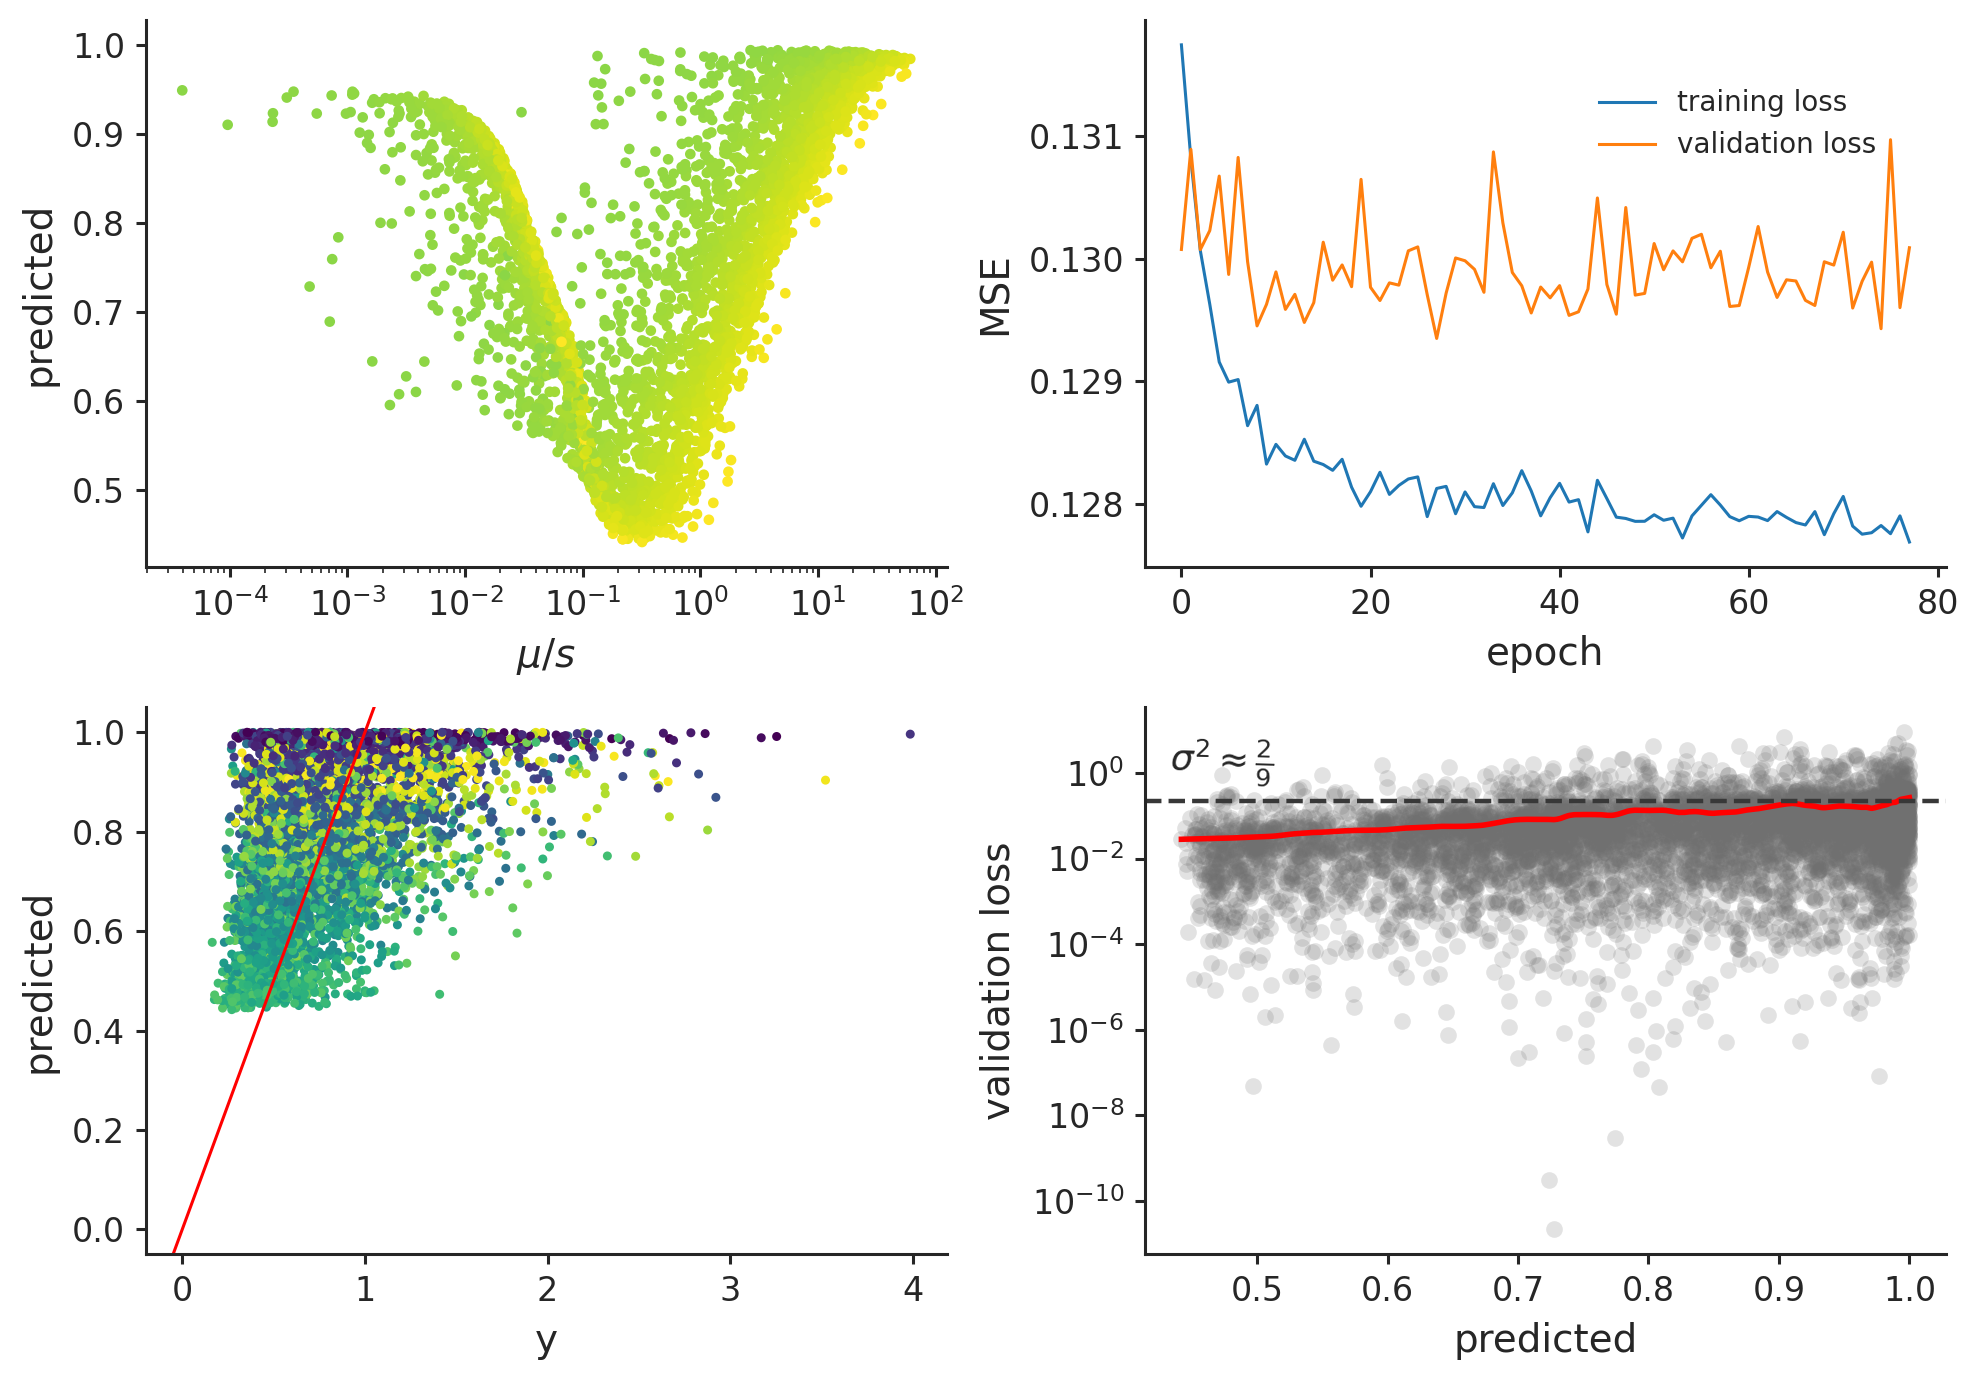

In [230]:
y_theory = bgs_rec(func.X_test_orig[:, 0], func.X_test_orig[:, 1], func.X_test_orig[:, 2], 1000)

mu_test, s_test, recrac_test = func.X_test.T
rate = mu_test/10**s_test

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

norm = plt.Normalize(np.min(mu_test), np.max(mu_test))

ax1.scatter(rate, predict, c=mu_test, cmap='viridis', s=8)
ax1.set_xlabel("$\mu/s$")
ax1.set_ylabel("predicted")
ax1.semilogx()
#cax1 = fig.add_axes([0.27, 0.8, 0.5, 0.05])
#fig.colorbar(cmap=cm.viridis, cax=cax1, orientation='horizontal')

#n = 10
#yedges = np.linspace(y_test.min(), y_test.max(), n)
#xedges = np.linspace(predict.min(), predict.max(), n)
#H, xedges, yedges = np.histogram2d(y_test.squeeze(), predict, bins=(xedges, yedges))
#X, Y = np.meshgrid(xedges, yedges)
#ax3.pcolormesh(X, Y, H)
ax3.scatter(func.y_test, predict, c=func.X_test[:, 1], s=5)
ax3.axline((0, 0), slope=1, c='r')
ax3.set_xlabel('y')
ax3.set_ylabel('predicted')

ly = (predict - func.y_test.squeeze())**2
lX = predict
ax4.scatter(lX, ly, color='0.44', 
            linewidth=0, edgecolor='black', alpha=0.2)
#ax4.set_ylim(-0.1, 3)
z = lowess(ly, lX, frac= 1/10, it=0)
ax4.plot(z[:, 0], z[:, 1], c='r', linewidth=2)

# the lowess fit was sensitive to it=0; this shows that the it=0 
# case is nearly identical to OLS, e.g. right thing to do
#mod = sm.OLS(ly, sm.add_constant(lX))
#res = mod.fit()
#lX_new = sm.add_constant(np.linspace(0.4, 1, 100))
#ax4.plot(lX_new, res.predict(lX_new), c='g')

xnew = np.linspace(0.4, 1, 100)
def B_var_limit(B, N, mu=1):
    return (3*mu + 8*B*N*mu**2)/(36*B*N)
ax4.axhline(B_var_limit(1, 1000), c='0.22', linewidth=1.6, linestyle='dashed') # Note the 1/2 factor — see sim_power.ipynb! TODO
#ax4.text(0.03, 0.88, "$\sigma^2 = \\frac{3 \mu + 8 B N \mu}{36 B N}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.text(0.03, 0.88, "$\sigma^2 \\approx \\frac{2}{9}$", size=13, rotation=-1.5, transform=ax4.transAxes)
ax4.semilogy()
ax4.set_ylabel('validation loss')
ax4.set_xlabel('predicted')

ax2.plot(history.history['loss'][1:], label='training loss')
ax2.plot(history.history['val_loss'][1:], label='validation loss')
ax2.set_ylabel("MSE")
ax2.set_xlabel("epoch")
#ax2.set_ylim((0, 1))
ax2.legend()
plt.tight_layout()

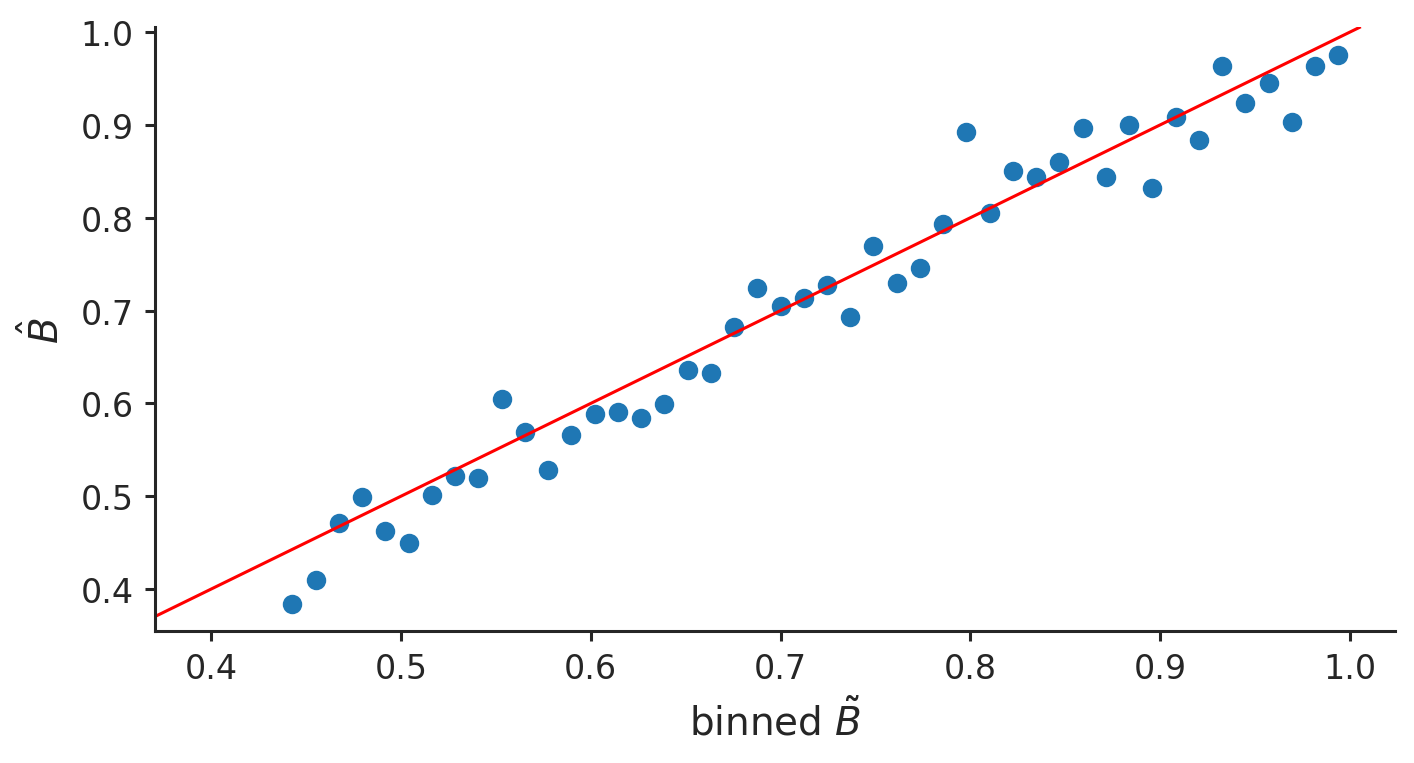

In [231]:
bins = np.linspace(0.4, 1, 50)
ytest_bins = stats.binned_statistic(predict, func.y_test.squeeze(), bins=bins)
fig, ax = plt.subplots()
ax.scatter(0.5*(bins[1:] + bins[:-1]), ytest_bins.statistic)
ax.set_ylabel('$\hat{B}$')
ax.set_xlabel('binned $\\tilde{B}$')
ax.axline((0.4, 0.4), slope=1, c='r')

In [232]:
# Note that the training data does not log10 mu, but here we do (otherwise the grid looks
# like chunky peanut butter).
(mu_grid, s_grid, _), X_mesh_orig, X_mesh, predict_grid = func.predict_grid({'mu': 101, 's': 100}, 
                                                                            fix_X={'recfrac': np.log10(1e-8)},
                                                                            log10=('mu'))

In [233]:
func.features

{'mu': 0, 's': 1, 'recfrac': 2}

In [234]:
X_mesh_orig

array([[-8.25963731, -4.        , -8.        ],
       [-8.22704094, -4.        , -8.        ],
       [-8.19444456, -4.        , -8.        ],
       ...,
       [-5.06519275, -1.        , -8.        ],
       [-5.03259637, -1.        , -8.        ],
       [-5.        , -1.        , -8.        ]])

In [245]:
np.log10(5.5e-9)

-8.259637310505756

In [235]:
ncontour = np.linspace(0.4, 0.96, 8)

Z = bgs_segment(10**X_mesh_orig[:, 0], 10**X_mesh_orig[:, 1], 10**X_mesh_orig[:, 2], 1e-8, 1000).reshape(predict_grid.shape).squeeze().T
Zp = predict_grid.squeeze().T

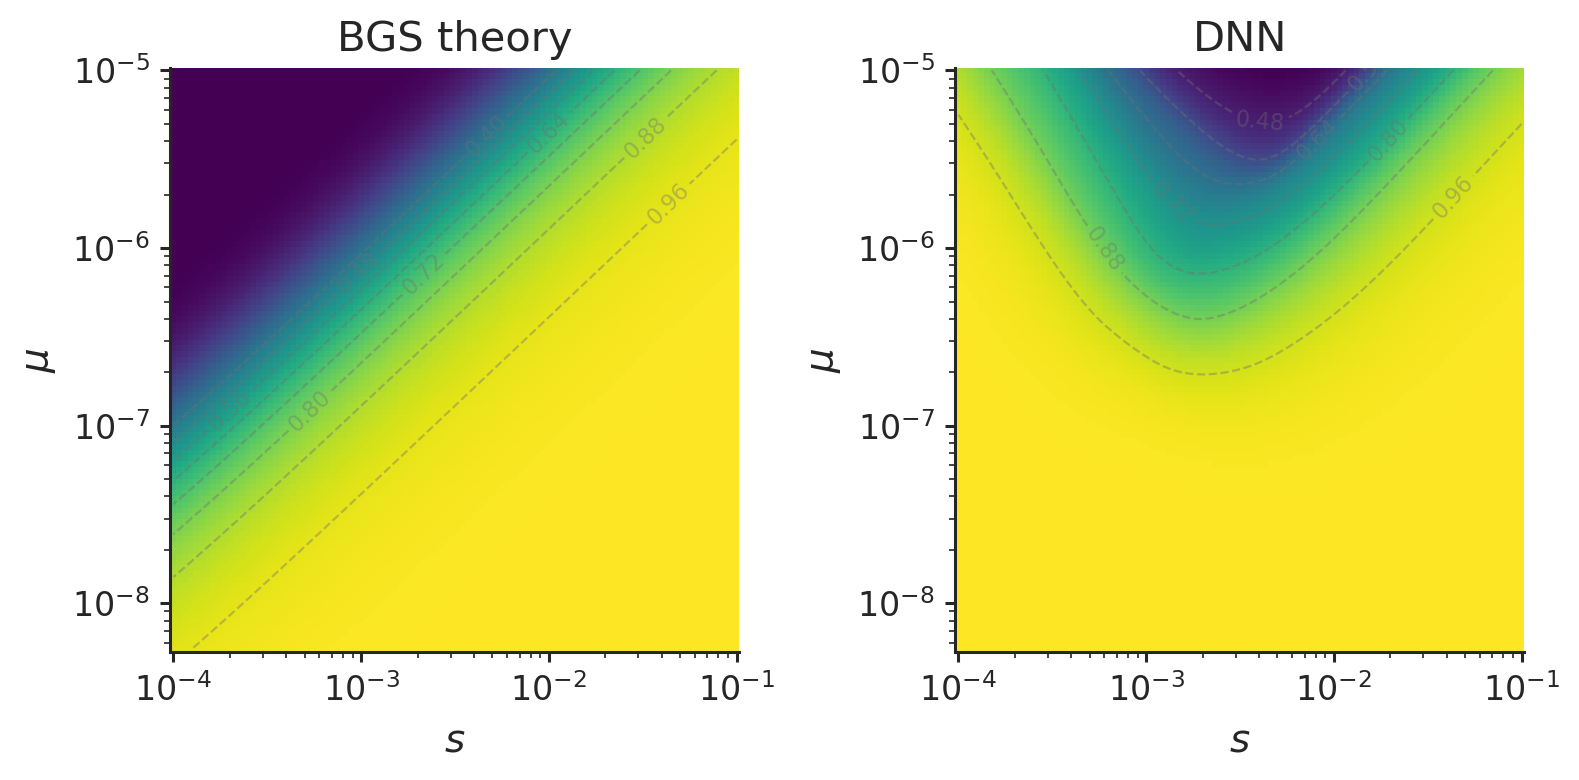

In [236]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

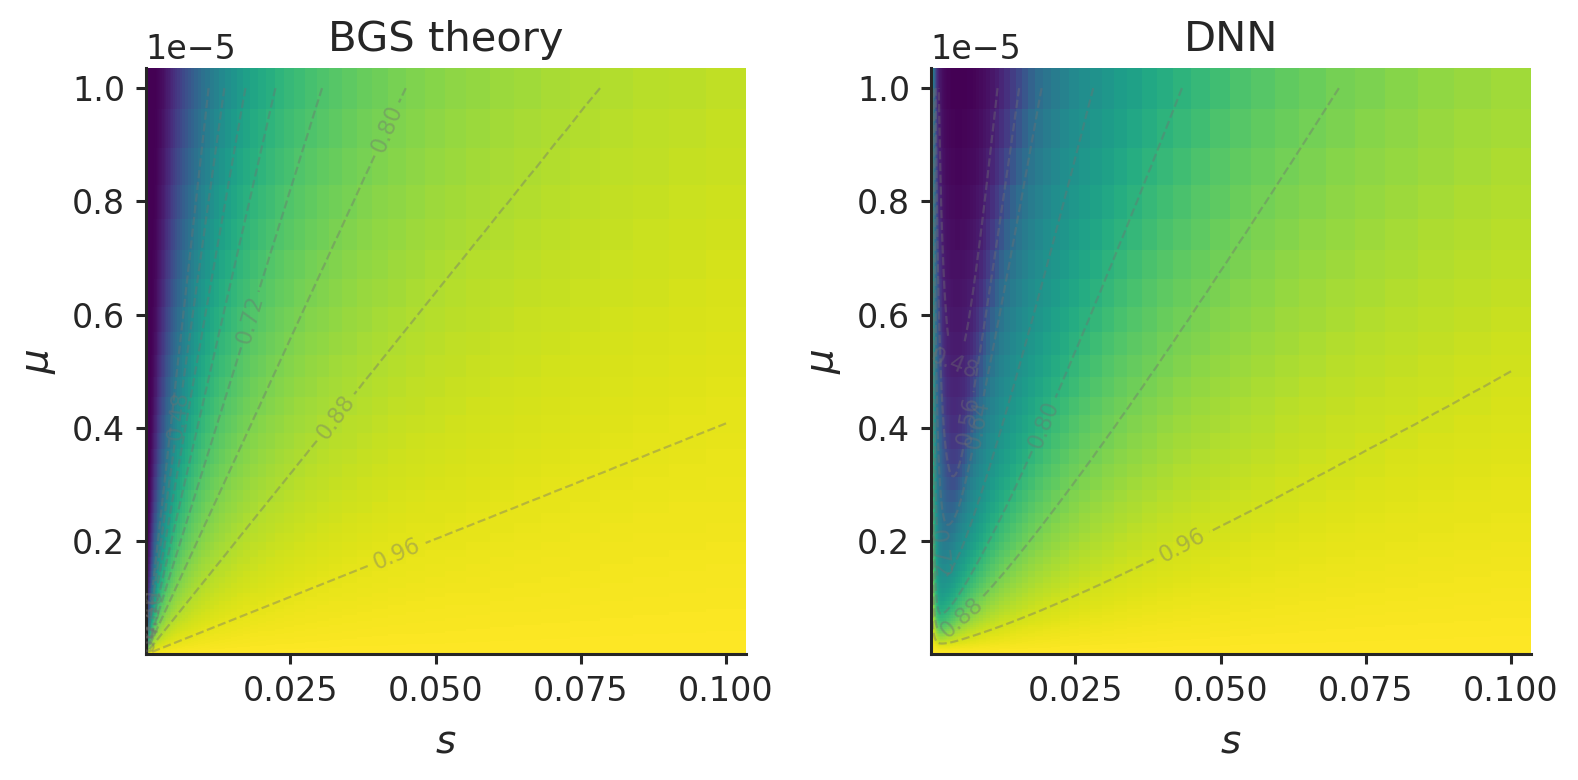

In [237]:
fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale=None, ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

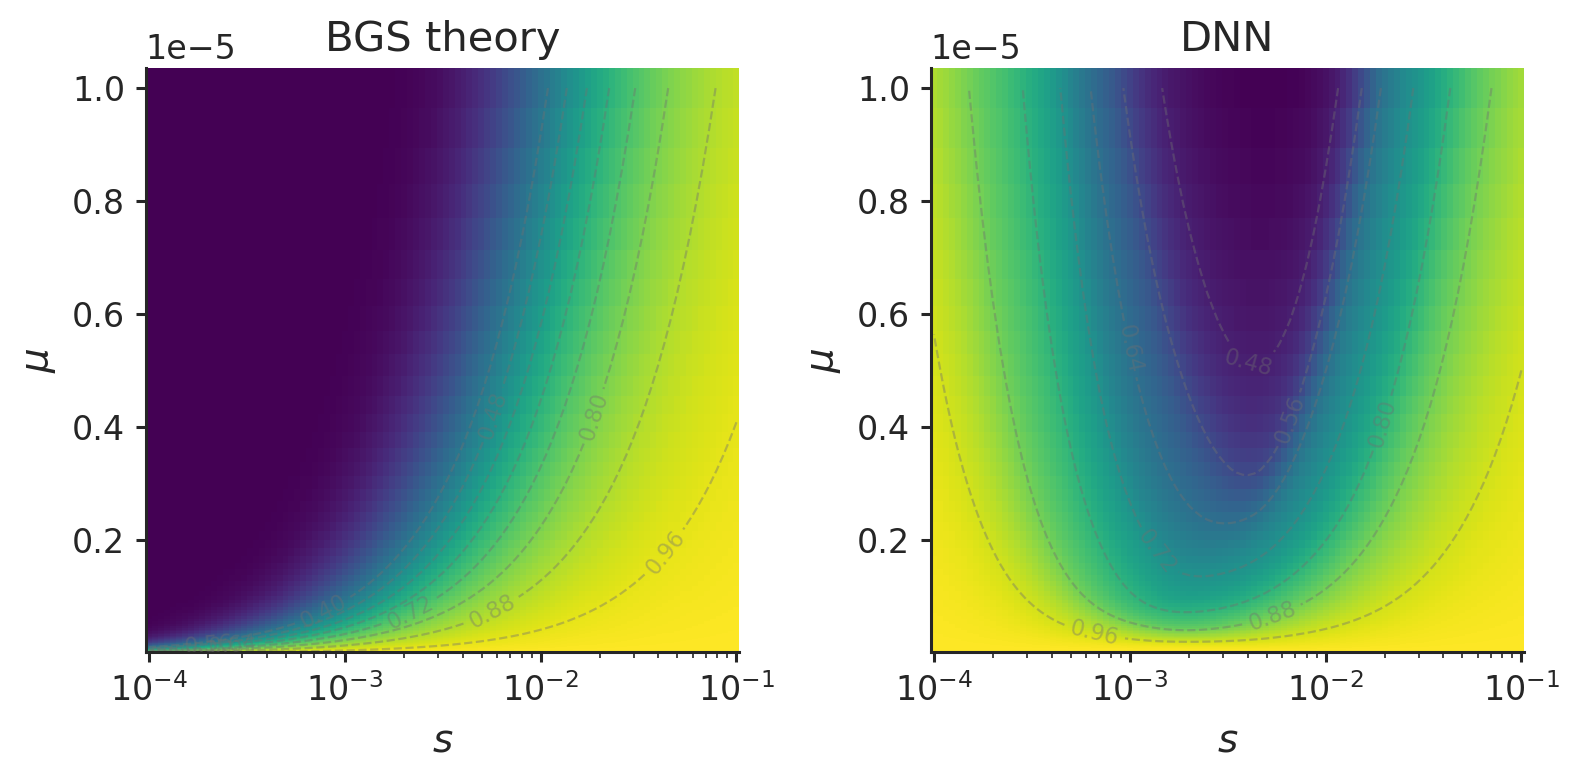

In [238]:

fig, ax = plt.subplots(ncols=2)
surface_plot(s_grid, mu_grid, Z, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[0]))
surface_plot(s_grid, mu_grid, Zp, scale='semilogx', ylabel="$\mu$", xlabel="$s$", ncontour=ncontour, figax=(fig, ax[1]))
ax[0].set_title("BGS theory")
ax[1].set_title("DNN")
plt.tight_layout()

(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot:xlabel='$s$', ylabel='$\\mu$'>)

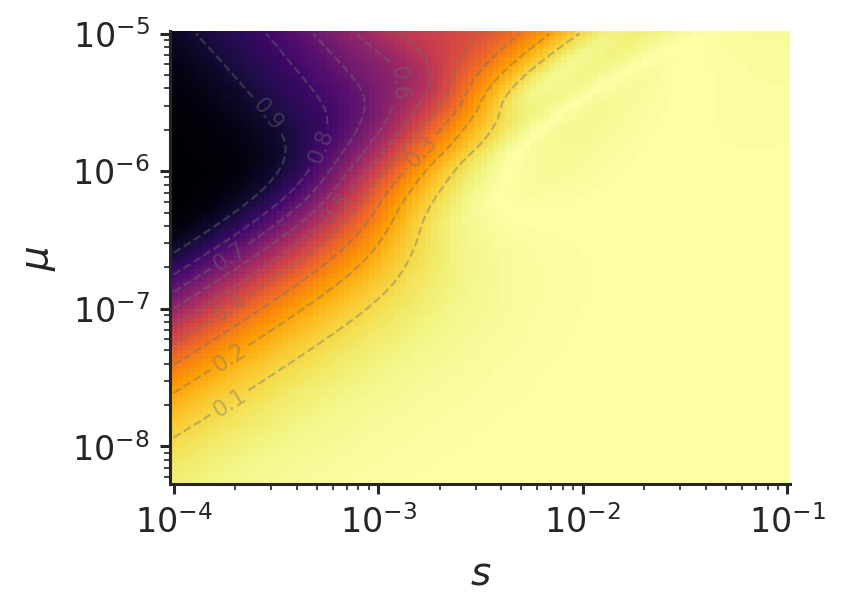

In [239]:
Zdiff = np.abs(Z-Zp)
figax = plt.subplots(figsize=(4, 3))
surface_plot(s_grid, mu_grid, Zdiff, scale='loglog', ylabel="$\mu$", xlabel="$s$", ncontour=10, cmap='inferno_r', figax=figax)


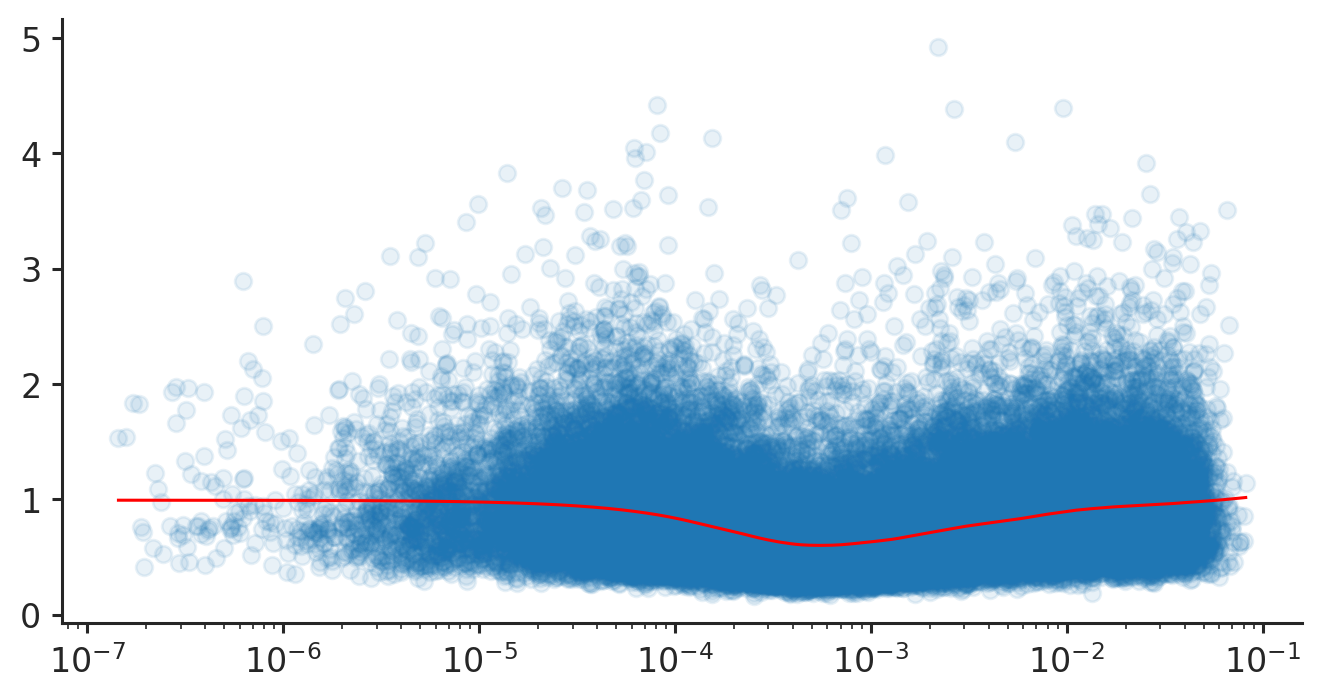

In [240]:
idx = Xo[:, 4] < 1
rate = Xo[idx, 3]/Xo[idx, 1]
yy = yo[idx, 1]
fig, ax = plt.subplots()
ax.scatter(rate, yy, alpha=0.1)

z = lowess(yy, rate, frac= 1./3, it=0)
ax.plot(z[:, 0], z[:, 1], c='r')
ax.set_xscale('log')

- make a kernel ridge vs DNN predicted surface plot
- weak impact on B can be caused by both BGS and weak selection
- is the mulitplicative right?


In [241]:
X.shape, y.shape


((57783, 3), (57783, 1))

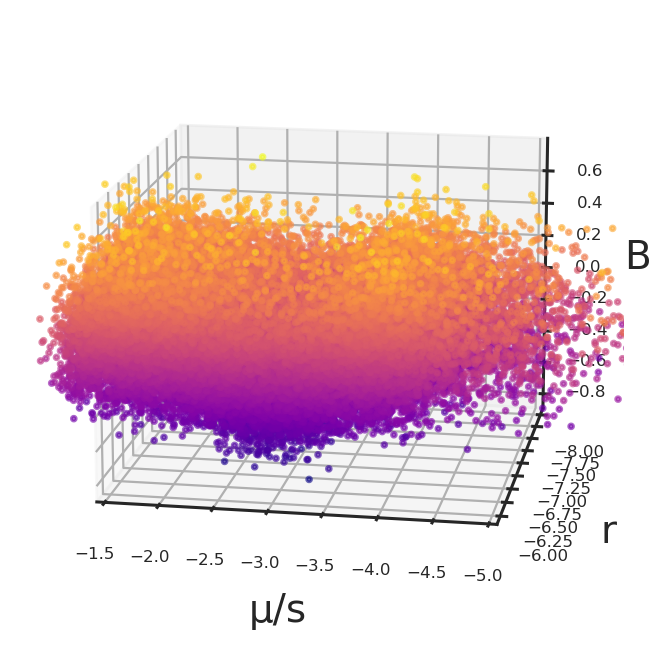

In [242]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(np.log10(X[:, 0]/X[:, 1]), np.log10(X[:, 2]), np.log10(y), s=3, c=np.log10(y), alpha=0.6, cmap='plasma')
#ax.scatter(X[:, 3], X[:, 1], y[:, 1], c=y[:, 1], cmap='viridis')

#ax.view_init(5, 270)
ax.view_init(15, 100)
ax.set_xlim(-5, -1.5)
ax.set_xlabel('μ/s')
ax.set_ylabel('r')
ax.set_zlabel('B')
ax.tick_params(axis='both', which='major', labelsize=6)
